In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline

# Import the pickled modeling data

In [48]:
partd = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partd.pkl')
partb = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partb.pkl')
dmepos = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/dmepos.pkl')

# Making target binary

In [49]:
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
dmepos.TARGET = dmepos.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

# Split data into train/test sets.

In [50]:
X_partb = partb.drop(columns=['TARGET'], axis=1)
y_partb = partb.TARGET

# Downsampling

In [56]:
from imblearn.under_sampling import RandomUnderSampler

In [57]:
rus = RandomUnderSampler(random_state=42)

X_partb, y_partb = rus.fit_sample(X_partb, y_partb)

# Train/Test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape, y_test.shape, X_test.shape)

(1224, 125) (1224,) (306,) (306, 125)


### Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

In [84]:
reg = LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

reg.fit(X_train, y_train)

/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [85]:
y_pred = reg.predict(X_test)

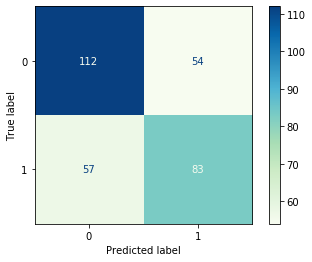

In [93]:
from sklearn import metrics

confusion_matrix = metrics.plot_confusion_matrix(reg, X_test, y_test, cmap= "GnBu")
confusion_matrix;

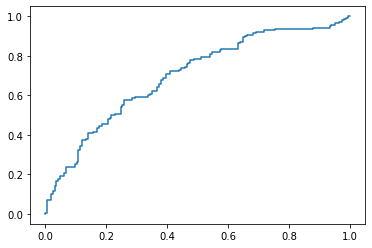

In [87]:
y_pred_prob = reg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)